## 1、用线性回归找到最佳拟合直线

> 优点：结果易于理解，计算上不复杂

> 缺点：对非线性的数据拟合不好

> 适用数据类型：数值型和标称型数据

平常说的回归，一般是指线性回归（linear regression）,从一堆数据中计算回归方程，需要一些评价指标。

误差采用平方误差：$\sum ^{m}_{i=1}\left( y_{i}-x^{T}_{i}w\right) ^{2}$

可以计算得到：$\widehat {w}=\left( x^{T}x\right) ^{-1}x^{T}y$

这就是最小二乘法（ordinary least squares，OLS）

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def loadDataSet(fileName):
    with open(fileName) as f:
        dataMat = []
        labelMat = []
        for line in f.readlines():
            lineArr = []
            curLine = line.strip().split('\t')
            for i in range(len(curLine)-1):
                lineArr.append(float(curLine[i]))
            dataMat.append(lineArr)
            labelMat.append(float(curLine[-1]))
    return np.array(dataMat), np.array(labelMat)

In [59]:
def standRegress(xArr, yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xTx = xMat.T*xMat
    if np.linalg.det(xTx) == 0.0:
        print('This matrix is singular, cannot do inverse')
        return
    ws = xTx.I*xMat.T*yMat
    return ws

In [7]:
xArr, yArr = loadDataSet('ex0.txt')
ws = standRegress(xArr, yArr)
ws

matrix([[ 3.00774324],
        [ 1.69532264]])

In [22]:
# plot
def plotRegression(xArr, yArr, ws):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr)
    figure, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(xMat[:, 1].flatten().A, yMat.flatten().A, c='b')
    xCopy = xMat.copy()
    yHat = xCopy*ws
    ax.plot(xCopy[:, 1], yHat, c='r')
    plt.show()

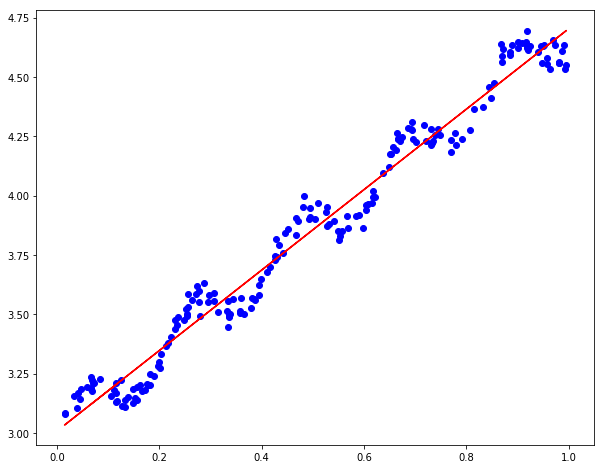

In [24]:
plotRegression(xArr, yArr, ws)

比较模型拟合的效果可以用相关系数来衡量

In [43]:
xMat = np.mat(xArr)
yMat = np.mat(yArr)
yHat = xMat * ws
np.corrcoef(yHat.T, yMat)

array([[ 1.        ,  0.98647356],
       [ 0.98647356,  1.        ]])

## 2、局部加权线性回归

线性回归的问题是有可能出现欠拟合现象，因为它求的是具有最小均方误差的无偏估计，因此有些方法允许在估计中引入一些偏差，从而降低预测的均方误差。

其中一个方法就是局部加权线性回归（locally weighted linear regression， LWLR）

公式如下：$\widehat {w}=\left( x^{T}Wx\right) ^{-1}x^{T}Wy$

LWLR使用“核”来对附近的点赋予更高的权重，常用高斯核：$w\left( i,i\right) =\exp \left( \dfrac {\left| x^{\left( i\right) }-x\right| }{-2k^{2}}\right)$

In [60]:
def lwlr(testPoint, xArr, yArr, k=1.0):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    m, n = xMat.shape
    # 创建对角矩阵
    weights = np.mat(np.eye(m))
    for j in range(m):
        diffMat = testPoint - xMat[j, :]
        weights[j, j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * weights * xMat
    if np.linalg.det(xTx) == 0.0:
        print('This matrix is singular, cannot do inverse')
        return
    ws = xTx.I * xMat.T * weights * yMat
    return testPoint * ws

In [61]:
def lwlrTest(testArr, xArr, yArr, k=1.0):
    m, n = testArr.shape
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    return yHat

In [46]:
xArr, yArr = loadDataSet('ex0.txt')
yArr[0]

3.176513

In [49]:
lwlr(xArr[0], xArr, yArr, 1.0)

matrix([[ 3.12204471]])

In [6]:
# plot
def plotLwlr(xArr, yArr, k):
    xArr = np.array(xArr)
    yArr = np.array(yArr)
    yHat = lwlrTest(xArr, xArr, yArr, k)
    
    # sort
    sortInd = xArr[:, 1].argsort(0)
    xSort = xArr[sortInd]
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(xArr[:, 1].flatten(), yArr, c='b')
    ax.plot(xSort[:, 1], yHat[sortInd], c='r', label='k={}'.format(k))
    plt.legend(loc='best')
    plt.show()

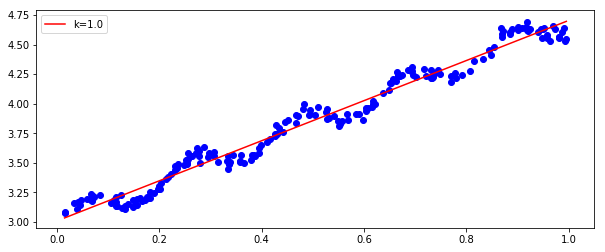

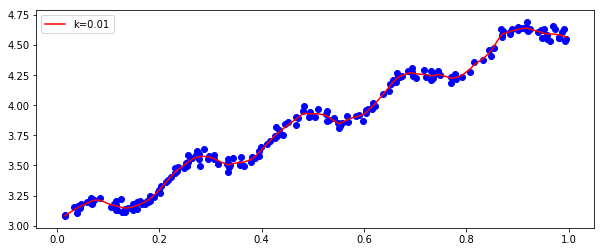

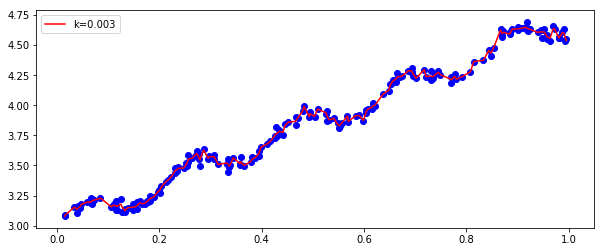

In [88]:
plotLwlr(xArr, yArr, 1.0)
plotLwlr(xArr, yArr, 0.01)
plotLwlr(xArr, yArr, 0.003)

三种不同的平滑值，可以看出k=1.0时与最小二乘法差不多，有些欠拟合，k=0.01时拟合效果最好，而k=0.003时则考虑了太多噪声导致过拟合。

> 缺点：局部加权线性回归增加了计算量，对每个点做预测时都需要使用整个数据集。

## 3、示例：预测鲍鱼的年龄

In [96]:
abX, abY = loadDataSet('abalone.txt')
abX[0], abY[0]

(array([ 1.    ,  0.455 ,  0.365 ,  0.095 ,  0.514 ,  0.2245,  0.101 ,  0.15  ]),
 15.0)

In [97]:
yHat01 = lwlrTest(abX[:99], abX[:99], abY[:99], 0.1)
yHat1 = lwlrTest(abX[:99], abX[:99], abY[:99], 1)
yHat10 = lwlrTest(abX[:99], abX[:99], abY[:99], 10)

In [78]:
def resError(yArr, yHat):
    return ((yArr - yHat)**2).sum()

In [100]:
print(resError(abY[0:99], yHat01.T))
print(resError(abY[0:99], yHat1.T))
print(resError(abY[0:99], yHat10.T))

56.9519167771
429.89056187
549.118170883


可以看出，使用较小的核可以得到较低的误差，但是这会造成数据过拟合，因此需要比较不同的核大小，才能得到比较好的拟合效果。

## 4、缩减系数来“理解”数据

如果数据的特征比样本点还多，就不能用之前的线性回归了，因为在计算$\left( X^{T}X\right) ^{-1}$的时候会出错。

为了解决这个问题，统计学家引入了岭回归（ridge regression）,另外是lasso法，以及前宰相逐步回归，效果与lasso差不多，但是更容易实现。

### 4.1 岭回归

岭回归就是在矩阵$X^{T}X$上加一个$\lambda I$使得矩阵非奇异，这样回归系数的计算公式将变为：$\widehat {w}=\left( X^{T}X+\lambda I\right) ^{-1}X^{T}y$

岭回归最先用于处理特征数多于样本数的情况，现在也用于在估计中假日偏差，从而得到更好的估计。这里通过引入$\lambda$限制了所有$w$之和，通过引入惩罚想，能减少不重要的参数，这个技术在统计学中叫做缩减（shrinkage）。

缩减方法可以去掉不重要的参数，因此能更好地理解数据。

In [62]:
def ridgeRegress(xMat, yMat, lam=0.2):
    xTx = xMat.T*xMat
    m, n = xMat.shape
    denom = xTx + np.eye(n)*lam
    if np.linalg.det(denom) == 0.0:
        print('This matrix is singular, cannot do inverse')
        return
    ws = denom.I * xMat.T * yMat
    return ws

In [63]:
def ridgeTest(xArr, yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    # 数据归一化
    yMean = np.mean(yMat, 0)
    yMat = yMat - yMean
    xMeans = np.mean(xMat, 0)
    xVar = np.var(xMat, 0)
    xMat = (xMat - xMeans) / xVar
    numTestPts = 30
    m, n = xMat.shape
    wMat = np.zeros((numTestPts, n))
    for i in range(numTestPts):
        ws = ridgeRegress(xMat, yMat, np.exp(i-10))
        wMat[i, :] = ws.T
    return wMat

In [18]:
# 在鲍鱼数据集上运行
abX, abY = loadDataSet('abalone.txt')
ridgeWeights = ridgeTest(abX, abY)

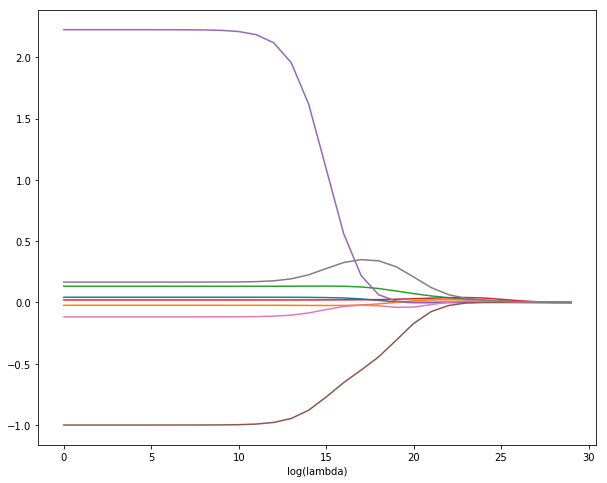

In [22]:
# plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ridgeWeights)
plt.xlabel('log(lambda)')
plt.show()

左边是不同$\lambda$的初始值，右边系数全部缩减为0.

### 4.2 lasso

在增加如下约束时，偏头痛的最小二乘法回归会得到与岭回归一样的公式：$\sum ^{n}_{k=1}w^{2}_{k}\leq \lambda$

另一个缩减方法lasso也对回归系数做了限定：$\sum ^{n}_{k=1}\left| w_{k}\right| \leq \lambda$

### 4.3 前向逐步回归

前向逐步回归算法可以得到与lasso差不多的效果，但更加简单，属于一种贪心算法，即每一步都尽可能减少误差。

In [84]:
def rssError(yArr, yHat):
    return ((yArr - yHat)**2).sum()

In [65]:
def stageWise(xArr, yArr, eps=0.01, numIter=100):
    xMat= np.mat(xArr)
    yMat = np.mat(yArr).T
    # 归一化
    yMean = np.mean(yMat, 0)
    yMat = yMat - yMean
    xMeans = np.mean(xMat, 0)
    xVar = np.var(xMat, 0)
    xMat = (xMat - xMeans) / xVar
    m, n = xMat.shape
    returMat = np.zeros((numIter, n))
    ws = np.zeros((n, 1))
    wsTest = ws.copy()
    wsMat = ws.copy()
    for i in range(numIter):
        #print(ws.T)
        lowestError = np.inf
        for j in range(n):
            for sign in [-1, 1]:
                wsTest = ws.copy()
                wsTest[j] += eps * sign
                yTest = xMat * wsTest
                rssE = rssError(yMat.A, yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returMat[i, :] = ws.T
    return returMat

In [40]:
xArr, yArr = loadDataSet('abalone.txt')
returnMat = stageWise(xArr, yArr, 0.001, 5000)
returnMat

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ..., 
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.044, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187]])

In [39]:
xMat = np.mat(xArr)
yMat = np.mat(yArr)
# 归一化
yMean = np.mean(yMat, 1)
yMat = yMat - yMean
xMeans = np.mean(xMat, 0)
xVar = np.var(xMat, 0)
xMat = (xMat - xMeans) / xVar
weights = standRegress(xMat, yMat)
weights.T

matrix([[ 0.0430442 , -0.02274163,  0.13214087,  0.02075182,  2.22403814,
         -0.99895312, -0.11725427,  0.16622915]])

当步长为0.001，迭代次数为5000时，前向逐步回归与最小二乘回归结果很接近。

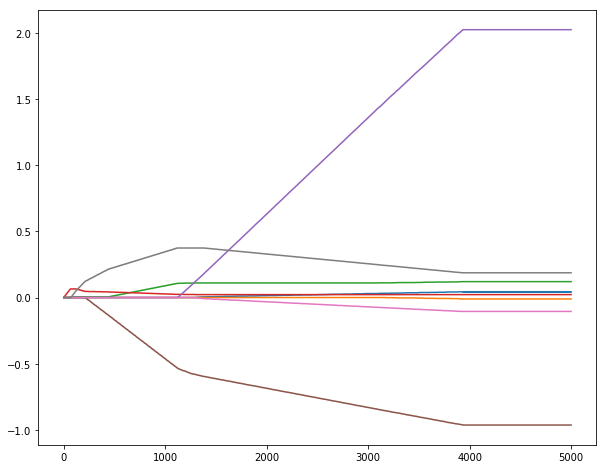

In [41]:
# plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(returnMat)
plt.show()

逐步线性回归的好处在于帮助人们理解现有的模型并做出改进，找出重要特征，即时停止对不重要特征的收集，提高生产效率。

当应用缩减方法（如逐步线性回归或岭回归）时，模型增加了偏差（bias），与此同时却减小了模型的方差。

## 5、权衡偏差与方差

误差（bias）是指模型与真是测量值之间的差异，要想获得low bias，就要复杂化模型，增加参数，但这样会造成过拟合（overfitting）,就会引起high variance，带来的不良影响是泛化能力差，在测试集上可能效果很差。

方差（variance）是描述在样本上训练出来的模型在测试集上的表现，要想获得low variance，就应该简化模型，减少参数，但这会造成欠拟合（underfitting）。

[示意图](./bias-var.jpg)

## 6、示例：预测乐高玩具套装的价格

In [2]:
# 需要解析html
from bs4 import BeautifulSoup

In [53]:
def searchForSet(retX, retY, inFile, yr, numPce, origPrc):
    with open('./setHtml/'+inFile, encoding='utf-8') as f:
        html = f.read()
    bsObj = BeautifulSoup(html, 'lxml')
    tables = bsObj.find_all('table', {'class': 'li'})
    for i in range(len(tables)):
        currItem = tables[i]
        title = currItem.find_all('a')[1].text
        lowerTitle = title.lower()
        if ('new' in lowerTitle) or ('nisb' in lowerTitle):
            newFlag = 1
        else:
            newFlag = 0
        soldPrice = currItem.find_all('td')[4]
        priceStr = soldPrice.text
        priceStr = priceStr.split('$')[1]
        priceStr = priceStr.replace(',', '')
        if len(soldPrice) > 1:
            priceStr = priceStr.replace('Free shipping', '')
        sellingPrice = float(priceStr)
        if sellingPrice > 0.5 * origPrc:
            print('{0}\t{1}\t{2}\t{3}\t{4}'.format(yr, numPce, newFlag, origPrc, sellingPrice))
            retX.append([yr, numPce, newFlag, origPrc])
            retY.append(sellingPrice)            

In [54]:
def setDataCollect(retX, retY):
    searchForSet(retX, retY, 'lego8288.html', 2006, 800, 49.99)
    searchForSet(retX, retY, 'lego10030.html', 2002, 3096, 269.99)
    searchForSet(retX, retY, 'lego10179.html', 2007, 5195, 499.99)
    searchForSet(retX, retY, 'lego10181.html', 2007, 3428, 199.99)
    searchForSet(retX, retY, 'lego10189.html', 2008, 5922, 299.99)
    searchForSet(retX, retY, 'lego10196.html', 2009, 3263, 249.99)

In [55]:
lgX = []
lgY = []
setDataCollect(lgX, lgY)

2006	800	0	49.99	85.0
2006	800	0	49.99	102.5
2006	800	0	49.99	77.0
2006	800	0	49.99	110.0
2006	800	0	49.99	162.5
2002	3096	0	269.99	699.99
2002	3096	0	269.99	602.0
2002	3096	0	269.99	515.0
2002	3096	0	269.99	510.0
2002	3096	0	269.99	375.0
2002	3096	1	269.99	1050.0
2002	3096	0	269.99	740.0
2002	3096	1	269.99	759.0
2002	3096	0	269.99	730.0
2002	3096	1	269.99	750.0
2007	5195	0	499.99	910.0
2007	5195	1	499.99	1199.99
2007	5195	0	499.99	811.88
2007	5195	0	499.99	1138.0
2007	5195	0	499.99	1324.79
2007	5195	1	499.99	850.0
2007	5195	1	499.99	800.0
2007	5195	0	499.99	810.0
2007	5195	1	499.99	1075.0
2007	5195	0	499.99	1050.0
2007	5195	1	499.99	1199.99
2007	5195	0	499.99	1342.31
2007	5195	1	499.99	1000.0
2007	5195	0	499.99	1780.0
2007	5195	0	499.99	750.0
2007	5195	1	499.99	1050.0
2007	5195	0	499.99	2204.99
2007	5195	0	499.99	1099.99
2007	5195	1	499.99	925.0
2007	5195	0	499.99	860.0
2007	5195	0	499.99	1675.0
2007	5195	1	499.99	1199.99
2007	5195	1	499.99	1099.99
2007	5195	1	499.99	1149.99
2007	5195

### 6.2 训练算法：建立模型

In [58]:
# 构建常数项
m, n = np.mat(lgX).shape
lgX1 = np.mat(np.ones((m, n+1)))
lgX1[:, 1:5] = np.mat(lgX)
lgX1[0]

matrix([[  1.00000000e+00,   2.00600000e+03,   8.00000000e+02,
           0.00000000e+00,   4.99900000e+01]])

In [66]:
ws = standRegress(lgX1, lgY)

In [76]:
ws

matrix([[  4.90452853e+04],
        [ -2.44669376e+01],
        [ -2.74330968e-02],
        [ -2.88831230e+01],
        [  2.66505136e+00]])

In [77]:
lgX1[1] * ws, lgY[0]

(matrix([[ 75.88799363]]), 85.0)

In [95]:
# 交叉验证测试岭回归
def crossValidation(xArr, yArr, numVal=10):
    m = len(yArr)
    indexList = list(range(m))
    errorMat = np.zeros((numVal, 30))
    for i in range(numVal):
        trainX = []
        trainY = []
        testX = []
        testY = []
        np.random.shuffle(indexList)
        for j in range(m):
            if j < m * 0.9:
                trainX.append(xArr[indexList[j]])
                trainY.append(yArr[indexList[j]])
            else:
                testX.append(xArr[indexList[j]])
                testY.append(yArr[indexList[j]])
        wMat = ridgeTest(trainX, trainY)
        for k in range(30):
            matTestX = np.mat(testX)
            matTrainX = np.mat(trainX)
            meanTrain = np.mean(matTrainX, 0)
            varTrain = np.var(matTrainX, 0)
            matTestX = (matTestX-meanTrain)/varTrain
            yEst = matTestX * np.mat(wMat[k, :]).T + np.mean(trainY)
            errorMat[i, k] = rssError(yEst.T.A, np.array(testY))
    meanErrors = np.mean(errorMat, 0)
    minMean = float(min(meanErrors))
    bestWeights = wMat[np.nonzero(meanErrors==minMean)]
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    meanX = np.mean(xMat, 0)
    varX = np.var(xMat, 0)
    unReg = bestWeights / varX
    print('the best model from Ridge Regression is: {0}'.format(unReg))
    print('with constant term: {0}'.format(-1*np.sum(np.multiply(meanX, unReg))+np.mean(yMat)))

In [97]:
crossValidation(lgX, lgY, 10)

the best model from Ridge Regression is: [[ -2.91633947e+01   1.51964540e-04  -1.74852438e+01   2.13216661e+00]]
with constant term: 58521.64098222057


> 总结：回归与分类的区别在于，前者预测的是连续性变量，后者预测离散型变量。这一章使用了传统的最小二乘法，当样本数小于特征数时需要采取特殊的策略，比如岭回归。

> 岭回归是缩减法的一种，相当于对回归系数的大小施加限制，另一种缩减法是lasso，可以使用简单的前向逐步回归解决。